Just load the Pima Indians Diabetes dataset

In [2]:
import pandas as pd

df = pd.read_csv('diabetes.csv')

print(f"DataFrame columns: {df.columns}\n")
print(f"DataFrame sample: {df.sample(10)}\n")

DataFrame columns: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

DataFrame sample:      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
534            1       77             56             30       56  33.3   
210            2       81             60             22        0  27.7   
188            8      109             76             39      114  27.9   
257            2      114             68             22        0  28.7   
344            8       95             72              0        0  36.8   
543            4       84             90             23       56  39.5   
66             0      109             88             30        0  32.5   
697            0       99              0              0        0  25.0   
11            10      168             74              0        0  38.0   
245            9      184             85             15      

## Univariate selection (8.3)
Apply the ANOVA F-test for classification (choose the most relevant variables)

In [3]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest #
from sklearn.feature_selection import f_classif # Anova F-value for classification tasks

# Split the array into input features (X) and target variable (Y)
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target

# SelectKBest feature selection using ANOVA F-test
test = SelectKBest(score_func=f_classif, k=4) 

# Fits selector to the data — calculates F-scores and p-values for each feature
fit = test.fit(X, y)

# Prints F-scores for each feature. Higher = more important
print(fit.scores_)

# According to the F-scores, the top 4 features are:
# 1. Glucose (score: ~213)
# 2. BMI (score: ~72)
# 3. Age (score: ~46)
# 4. Pregnancies (score: ~40)


# Transforms original data to include only selected top 4 features
features = fit.transform(X) 

# I convert it back to a DataFrame for better readability (with column names)
selected_features_df = pd.DataFrame(features, columns=X.columns[test.get_support()])

# Show first 5 rows
print(selected_features_df.head())

[ 39.67022739 213.16175218   3.2569504    4.30438091  13.28110753
  71.7720721   23.8713002   46.14061124]
   Pregnancies  Glucose   BMI   Age
0          6.0    148.0  33.6  50.0
1          1.0     85.0  26.6  31.0
2          8.0    183.0  23.3  32.0
3          1.0     89.0  28.1  21.0
4          0.0    137.0  43.1  33.0


#### What happens next?
Let's try to train a model with and without the ANOVA F-test classification and see how things go?

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split before feature selection 
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2 = X_train_1.copy()
X_test_2 = X_test_1.copy()
y_train_2 = y_train_1.copy()
y_test_2 = y_test_1.copy()

model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train_1, y_train_1)

score1 = model1.score(X_test_1, y_test_1)
print(f"Model 1 accuracy: {score1:.2f}")

# Apply selector on training data only
selector = SelectKBest(score_func=f_classif, k=4)
X_train_selected = selector.fit_transform(X_train_2, y_train_2)

# Show the selected features
mask = selector.get_support()
selected_features = X_train_2.columns[mask]
print("Selected features:", selected_features.tolist())

# Transform test data using the same selector
X_test_selected = selector.transform(X_test_2)

# Train model on selected features
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train_selected, y_train_2)

# Evaluate
score2 = model2.score(X_test_selected, y_test_2)
print(f"Model 2 accuracy: {score2:.2f}")

# Well, indeed it has improved! Ahh you should have seen that coming!

Model 1 accuracy: 0.72
Selected features: ['Pregnancies', 'Glucose', 'BMI', 'Age']
Model 2 accuracy: 0.77


## Recursive Feature Elimination - RFE (8.4)
Popular feature elimination method for small samples. Reducing the unrelevant features will improve the performance of the generalization

Num Features: 3
Selected Features: [ True  True False False False  True False False]
Selected Features: ['Pregnancies', 'Glucose', 'BMI']
Feature Ranking: [1 1 3 6 5 1 2 4]


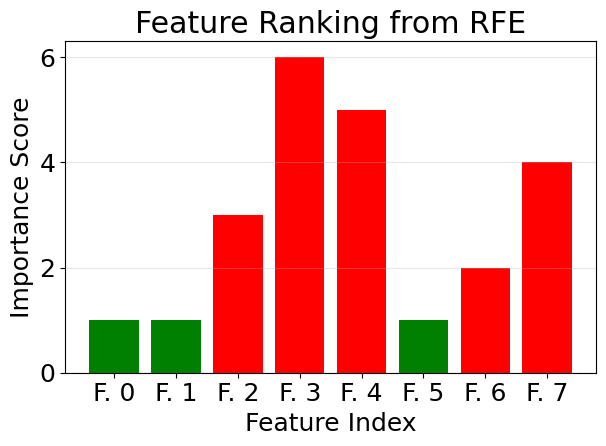

In [93]:
from matplotlib import pyplot
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Split the df into input features (X) and target variable (Y)
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target

# Keep the original feature names for later reference
feature_names = X.columns.tolist()

# Standardize the features (highly recommended for RFE)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Let's trhow a logistic regression model into the mix
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# Recursive Feature Elimination (RFE) to select top 3 features
rfe = RFE(model, n_features_to_select=3) 
fit = rfe.fit(X, y)

# Get the selected feature names
selected_features = [feature_names[i] for i, support in enumerate(fit.support_) if support]

# Print the results
print("Num Features: %s" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

# plot the feature importance
colors = ['green' if selected else 'red' for selected in fit.support_]
pyplot.bar(range(len(fit.ranking_)), fit.ranking_, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Ranking from RFE')
pyplot.xticks(range(len(fit.ranking_)), [f'F. {i}' for i in range(len(fit.ranking_))])
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()

#### What happens next?

Again, let's train a model with all the features VS the Recursive Feature Elimination (RFE) and see the magic

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split before feature selection 
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2 = X_train_1.copy()
X_test_2 = X_test_1.copy()
y_train_2 = y_train_1.copy()
y_test_2 = y_test_1.copy()

# Train the first model on all the features
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train_1, y_train_1)
score1 = model1.score(X_test_1, y_test_1)
print(f"Model 1 accuracy: {score1:.2f}")

# NOW we apply the RFE selector on training data only
# Use the selected features from the previous RFE
# Convert feature names to their corresponding column indices
selected_indices = [feature_names.index(name) for name in selected_features]

# Create new datasets with only the selected features
X_train_selected = X_train_2[:, selected_indices]
X_test_selected = X_test_2[:, selected_indices]

# Train and evaluate the new model on selected features
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train_selected, y_train_2)
score2 = model2.score(X_test_selected, y_test_2)
print(f"Model 2 accuracy: {score2:.2f}")

# Indeed we see an improvement in accuracy!

Model 1 accuracy: 0.73
Model 2 accuracy: 0.78


## Attributes importance (8.5) 
Let's review techniques that assign a numerical score to each attribute based on its relevance to the model's goal

#### Linear regression coefficients
This code beow demonstrates feature importance analysis using **linear regression coefficients**. And note that here we *just* give a score to each variable, **we are not selecting features**. The coefficients just tells us the relative importance/contribution of each feature. Also importantly here **we do need to fit the model to get the coefficients** because the coefficients represent the learned relationship between features and target.

The linear Regression is good for:
- Predicting continious values (prices, temperatures, scores...)
- Using coefficients to show how much each feature changes the output

Feature Importance Scores:
Feature 0: -0.0000
Feature 1: 63.6430
Feature 2: 70.6476
Feature 3: 10.4568
Feature 4: 16.7483
Feature 5: 0.0000
Feature 6: -0.0000
Feature 7: 0.0000
Feature 8: 3.1586
Feature 9: 0.0000


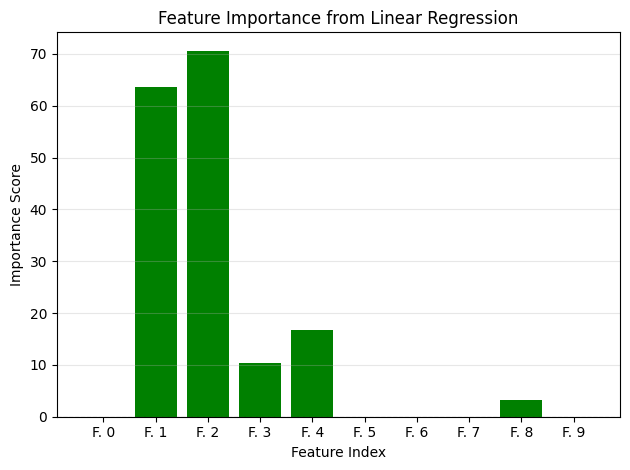

In [1]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# Generate synthetic regression data
# * note that the n_informative parameter controls how many features are actually useful for prediction
X, y = make_regression(n_samples=100, n_features=10, n_informative=5, random_state=42)

# Define the model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get importance scores
importance_scores = model.coef_

# Print the importance scores
print("Feature Importance Scores:")
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: {score:.4f}")  

# plot the feature importance
colors = ['green' if selected else 'red' for selected in importance_scores > 0]
pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from Linear Regression')
pyplot.xticks(range(len(importance_scores)), [f'F. {i}' for i in range(len(importance_scores))])
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()

Ok that was cool, but I'd prefer to do the same test on the same dataset as before (Pima Indians Diabetes dataset) with two goals:
1. Understand this methodology better with "real" variables
2. Compare its feature selection with previous (and maybe upcoming) methods

STEP 1: MODEL WITH ALL FEATURES
Feature Importance Scores:
Feature 0 (Pregnancies): 0.0693
Feature 1 (Glucose): 0.1892
Feature 2 (BloodPressure): -0.0451
Feature 3 (SkinThickness): 0.0025
Feature 4 (Insulin): -0.0208
Feature 5 (BMI): 0.1044
Feature 6 (DiabetesPedigreeFunction): 0.0488
Feature 7 (Age): 0.0308


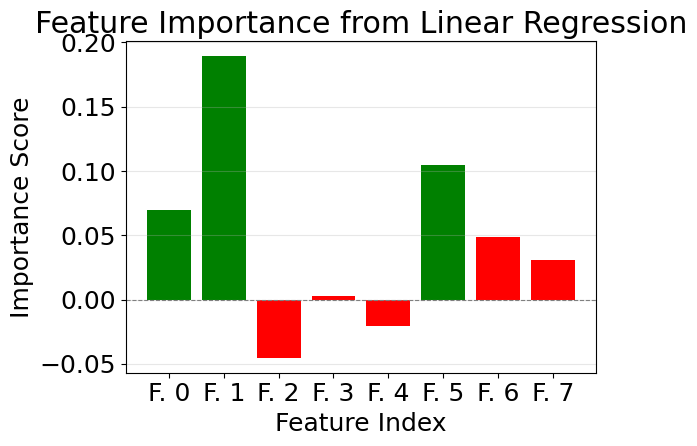


FULL MODEL PERFORMANCE:
Mean Absolute Error (MAE): 0.3322
R² Score: 0.3033

STEP 2: FEATURE SELECTION BASED ON COEFFICIENTS
Selected 6 out of 8 features:
  - Pregnancies (coef: 0.0693)
  - Glucose (coef: 0.1892)
  - BloodPressure (coef: -0.0451)
  - BMI (coef: 0.1044)
  - DiabetesPedigreeFunction (coef: 0.0488)
  - Age (coef: 0.0308)

STEP 3: MODEL WITH SELECTED FEATURES ONLY
SELECTED FEATURES MODEL PERFORMANCE:
Mean Absolute Error (MAE): 0.3326
R² Score: 0.3018

COMPARISON SUMMARY
Full Model    - Features: 8, MAE: 0.3322, R²: 0.3033
Selected Model - Features: 6, MAE: 0.3326, R²: 0.3018

Changes after feature selection:
Features reduced by: 2
MAE change: +0.0004 (worse)
R² change: -0.0015 (worse)


In [96]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Split the df into input features (X) and target variable (Y)
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target

# Keep the original feature names for later reference
feature_names = X.columns.tolist()

# Standardize the features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ********************************************************************
print("="*60)
print("STEP 1: MODEL WITH ALL FEATURES")
print("="*60)

# Let's build the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

y_pred = model.predict(X)

# Get importance scores
importance_scores = model.coef_

# Print the importance scores
# Again, note that here we are using the coefficients of the linear regression model as importance scores, not selecting features.
print("Feature Importance Scores:")
for i, score in enumerate(importance_scores):
    print(f"Feature {i} ({feature_names[i]}): {score:.4f}")

# plot the feature importance
importances = np.abs(model.coef_)
colors = ['green' if selected else 'red' for selected in importances >= 0.05]
pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from Linear Regression')
pyplot.xticks(range(len(importance_scores)), [f'F. {i}' for i in range(len(importance_scores))])
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()
# IMPORTANT: The colors here are just for visualization purposes and DO NOT 
# indicate feature selection.

# Calculate MAE and R²
mae_full = mean_absolute_error(y, y_pred)
r2_full = r2_score(y, y_pred)

print(f"\nFULL MODEL PERFORMANCE:")
print(f"Mean Absolute Error (MAE): {mae_full:.4f}")
print(f"R² Score: {r2_full:.4f}")

# ********************************************************************
print("\n" + "="*60)
print("STEP 2: FEATURE SELECTION BASED ON COEFFICIENTS")
print("="*60)

# Define selection criteria (you can adjust this threshold)
threshold = 0.025  # Select features with absolute coefficient > threshold
selected_indices = [i for i, score in enumerate(importance_scores) if abs(score) > threshold]
selected_features = [feature_names[i] for i in selected_indices]

print(f"Selected {len(selected_features)} out of {len(feature_names)} features:")
for i, feature in enumerate(selected_features):
    original_idx = selected_indices[i]
    print(f"  - {feature} (coef: {importance_scores[original_idx]:.4f})")

# ********************************************************************
print("\n" + "="*60)
print("STEP 3: MODEL WITH SELECTED FEATURES ONLY")
print("="*60)

# Create new dataset with only selected features
X_selected = X[:, selected_indices]

# Build new model with selected features only
model_selected = LinearRegression()
model_selected.fit(X_selected, y)
y_pred_selected = model_selected.predict(X_selected)

# Calculate performance metrics for selected model
mae_selected = mean_absolute_error(y, y_pred_selected)
r2_selected = r2_score(y, y_pred_selected)

print(f"SELECTED FEATURES MODEL PERFORMANCE:")
print(f"Mean Absolute Error (MAE): {mae_selected:.4f}")
print(f"R² Score: {r2_selected:.4f}")

print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

print(f"Full Model    - Features: {len(feature_names)}, MAE: {mae_full:.4f}, R²: {r2_full:.4f}")
print(f"Selected Model - Features: {len(selected_features)}, MAE: {mae_selected:.4f}, R²: {r2_selected:.4f}")

# Performance comparison
mae_diff = mae_selected - mae_full
r2_diff = r2_selected - r2_full
feature_reduction = len(feature_names) - len(selected_features)

print(f"\nChanges after feature selection:")
print(f"Features reduced by: {feature_reduction}")
print(f"MAE change: {mae_diff:+.4f} ({'worse' if mae_diff > 0 else 'better'})")
print(f"R² change: {r2_diff:+.4f} ({'better' if r2_diff > 0 else 'worse'})")

# In this case, we see that the model with less selected features has a very
# similar performance (but lower) compared to the full model, but with fewer features, 
# which is often desirable in practice if performance is required.

#### Logistic regression coefficients
In logistic regression, the coefficients represent how much each feature increases/decreases the log-odds of the positive class.<br>
**The feature selection process stays exactly the same**: we still use coefficient magnitude to rank feature importance!

The Logistic Regression is useful to:
- **Predict probabilities and classes** (e.g. 0 or 1, Yes or No, Spam/Not Spam) instead of continous values
- Uses coefficients to show how much each feature affects the log-odds of the outcome
<br><br><br>
In the code below, let's do an example with a randomly generated dataset.

Feature 0: 0.3741
Feature 1: 0.6766
Feature 2: 0.5561
Feature 3: 0.4399
Feature 4: -0.0376
Feature 5: -0.7521
Feature 6: -0.3624
Feature 7: -1.2094
Feature 8: 0.3820
Feature 9: 0.3887


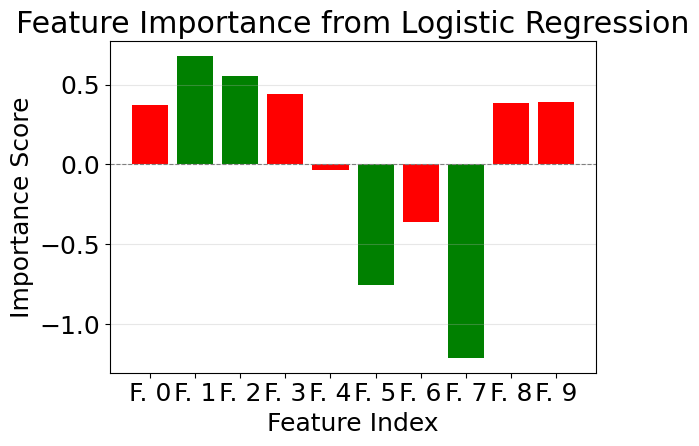

In [97]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# define a synthetic dataset
X, y = make_classification(n_samples=100, n_features=10, 
                           n_informative=5, n_redundant=5, random_state=42)

# define the model
model = LogisticRegression()

# fit the model
model.fit(X, y)

# get the feature importance scores
importance_scores = model.coef_[0]

# summarize feature importance
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: {score:.4f}")

# plot the feature importance
importances = np.abs(importance_scores)
colors = ['green' if selected else 'red' for selected in importances >= 0.45]
pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from Logistic Regression')
pyplot.xticks(range(len(importance_scores)), [f'F. {i}' for i in range(len(importance_scores))])
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()
# IMPORTANT: The colors here are just for visualization purposes and DO NOT 
# indicate feature selection.

Let's now check with a non-random dataset, we will use the Pima Indians Diabetes dataset again

Feature 0 (Pregnancies): 0.4088
Feature 1 (Glucose): 1.1073
Feature 2 (BloodPressure): -0.2508
Feature 3 (SkinThickness): 0.0090
Feature 4 (Insulin): -0.1308
Feature 5 (BMI): 0.6964
Feature 6 (DiabetesPedigreeFunction): 0.3089
Feature 7 (Age): 0.1766


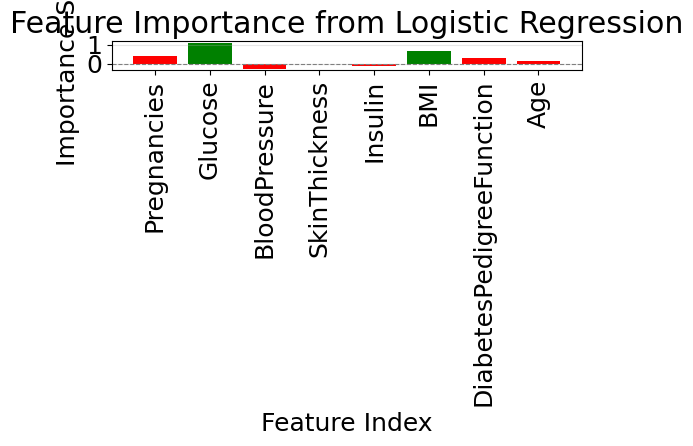

In [98]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# Split the df into input features (X) and target variable (Y)
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target

# Keep the original feature names for later reference
feature_names = X.columns.tolist()

# Standardize the features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# define the model
model = LogisticRegression()

# fit the model
model.fit(X, y)

# get the feature importance scores
importance_scores = model.coef_[0]

# summarize feature importance
for i, score in enumerate(importance_scores):
    print(f"Feature {i} ({feature_names[i]}): {score:.4f}")

# plot the feature importance
importances = np.abs(importance_scores)
colors = ['green' if selected else 'red' for selected in importances >= 0.45]
pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from Logistic Regression')
pyplot.xticks(range(len(importance_scores)), 
[f'{feature_names[i]}' for i in range(len(importance_scores))], rotation=90)
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()
# IMPORTANT: The colors here are just for visualization purposes and DO NOT 
# indicate feature selection.

**Wrap up: Logistic VS Linear Regression**
Main differences between the Linear and Logistic Regression:
- Purpose: Linear predicts continuous values, Logistic predicts categories/classes
- Output: Linear gives any real number, Logistic gives probabilities (0-1) and class predictions
- Use cases: Linear for prices/temperatures/scores, Logistic for yes/no/spam/disease diagnosis
- Relationship: Linear assumes straight-line relationship, Logistic uses S-shaped curve
- Performance metrics: Linear uses MAE/R², Logistic uses accuracy/precision/recall
- Coefficients meaning: Linear shows direct impact on output value, Logistic shows impact on log-odds of positive class
- Assumptions: Linear assumes normal distribution of errors, Logistic assumes binary outcomes


#### Attribute Permutation importance *with KNeighborsRegressor*

The algorithm introduces some randomness by randomly reordering the values in one column and then examines the outcome (such as model accuracy). This is how it detects which columns are relevant for modeling.

Feature 0: -56.2611
Feature 1: 3446.0127
Feature 2: 4302.1408
Feature 3: 53.3100
Feature 4: 221.0184
Feature 5: 163.9285
Feature 6: 91.1745
Feature 7: 66.6719
Feature 8: -177.0566
Feature 9: 106.9544
Threshold (mean): 868.4529


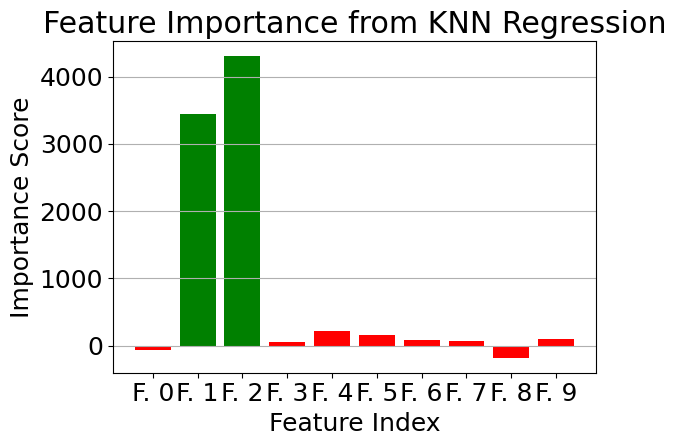

In [99]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

# define dataset
X, y = make_regression(n_samples=100, n_features=10, n_informative=5, random_state=42)

# define the model
model = KNeighborsRegressor()

# fit the model
model.fit(X, y)

# perform permutation importance
results = permutation_importance(model, X, y, 
                                scoring="neg_mean_squared_error", random_state=42)

# get importance scores
importance_scores = results.importances_mean

# summarize feature importance
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: {score:.4f}")

# plot the feature importance
importances_abs = np.abs(importance_scores)
threshold = np.mean(importances_abs) # Decide threshold (e.g., mean of importances)
print(f"Threshold (mean): {threshold:.4f}")
colors = ['green' if selected >= threshold else 'red' for selected in importances_abs]

pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from KNN Regression')
pyplot.xticks(range(len(importance_scores)), [f'F. {i}' for i in range(len(importance_scores))])
pyplot.tight_layout()
pyplot.grid(axis='y', visible=True)
pyplot.show()
# NOTE the colors are illustrative, I'm not saying we should choose those specific 
# columns as the ones for a potential model, and discard everything else. Such decision
# would require further consideration 

Let's apply the attribute permutation technique through a KNN Regression with the diabetes dataset

Feature 0: 0.0285
Feature 1: 0.0715
Feature 2: 0.0165
Feature 3: 0.0192
Feature 4: 0.0148
Feature 5: 0.0279
Feature 6: 0.0210
Feature 7: 0.0283
Threshold (mean): 0.0228


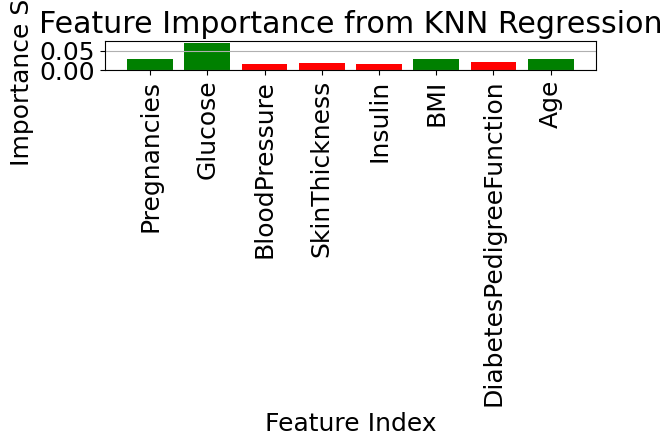


PREDICTIONS COMPARISONS

🔍 MODEL 1: Using ALL features
----------------------------------------
Used features: 8 (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age)
MSE: 0.1945
MAE: 0.3234
R²:  0.1526

🎯 MODEL 2:Using only selected features
--------------------------------------------------
Selected indexes: [0, 1, 5, 7]
Corresponding features: ['Pregnancies', 'Glucose', 'BMI', 'Age']
Used features: 4 (Pregnancies, Glucose, BMI, Age)
MSE: 0.1675
MAE: 0.3052
R²:  0.2703

📈 DIFFERENCES (Absolute & Percentual):
MSE: -0.0270 (-13.9%) (better)
MAE: -0.0182 (-5.6%) (better)
R²:  +0.1177 (+77.1%) (better)

💡 CONCLUSION:
✅ The model with fewer features has better performance!
   This suggests that some features were introducing noise.


In [100]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# define dataset
# Split the df into input features (X) and target variable (Y)
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target

# Keep the original feature names for later reference
feature_names = X.columns.tolist()

# Standardize the features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# define the model
model = KNeighborsRegressor()

# fit the model
model.fit(X, y)

# perform permutation importance
results = permutation_importance(model, X, y, 
                                scoring="neg_mean_squared_error", random_state=42)

# get importance scores
importance_scores = results.importances_mean

# summarize feature importance
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: {score:.4f}")

# plot the feature importance
importances_abs = np.abs(importance_scores)
threshold = np.mean(importances_abs) * 0.8 # Decide threshold (e.g., mean of importances)
print(f"Threshold (mean): {threshold:.4f}")
colors = ['green' if selected >= threshold else 'red' for selected in importances_abs]

pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from KNN Regression')
pyplot.xticks(range(len(importance_scores)), 
    [f'{feature_names[i]}' for i in range(len(importance_scores))], rotation=90)
pyplot.tight_layout()
pyplot.grid(axis='y', visible=True)
pyplot.show()
# NOTE the colors are illustrative, I'm not saying we should choose those specific 
# columns as the ones for a potential model, and discard everything else. Such decision
# would require further consideration

# You know what... nothing prevents us to test other than laziness. Let's overcome it
print("\n" + "="*60)
print("PREDICTIONS COMPARISONS")
print("="*60)

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize both sets
scaler_full = StandardScaler()
X_train_scaled = scaler_full.fit_transform(X_train)
X_test_scaled = scaler_full.transform(X_test)

# === MODEL 1: ALL THE FEATURES ===
print("\n🔍 MODEL 1: Using ALL features")
print("-" * 40)

model_full = KNeighborsRegressor(n_neighbors=5)
model_full.fit(X_train_scaled, y_train)
y_pred_full = model_full.predict(X_test_scaled)

# Full model KPIs
mse_full = mean_squared_error(y_test, y_pred_full)
mae_full = mean_absolute_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

print(f"Used features: {len(feature_names)} ({', '.join(feature_names)})")
print(f"MSE: {mse_full:.4f}")
print(f"MAE: {mae_full:.4f}")
print(f"R²:  {r2_full:.4f}")

# === MODEL 2: ONLY CHOSEN FEATURES ===
print("\n🎯 MODEL 2:Using only selected features")
print("-" * 50)

# Chosen features
selected_feature_names = ['Pregnancies', 'Glucose', 'BMI', 'Age']

# Find the indexes of the chosen features
selected_indices = []
available_feature_names = []

for name in selected_feature_names:
    if name in feature_names:
        idx = feature_names.index(name)
        selected_indices.append(idx)
        available_feature_names.append(name)

print(f"Selected indexes: {selected_indices}")
print(f"Corresponding features: {available_feature_names}")

# Select only these columns using indexes
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

# Standarize the selected features
scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

model_selected = KNeighborsRegressor(n_neighbors=5)
model_selected.fit(X_train_selected_scaled, y_train)
y_pred_selected = model_selected.predict(X_test_selected_scaled)

# Reduced model KPIs
mse_selected = mean_squared_error(y_test, y_pred_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f"Used features: {len(available_feature_names)} ({', '.join(available_feature_names)})")
print(f"MSE: {mse_selected:.4f}")
print(f"MAE: {mae_selected:.4f}")
print(f"R²:  {r2_selected:.4f}")

# Calculate percentage and difference
mse_diff = mse_selected - mse_full
mae_diff = mae_selected - mae_full
r2_diff = r2_selected - r2_full

mse_diff_pct = ((mse_selected - mse_full) / mse_full) * 100
mae_diff_pct = ((mae_selected - mae_full) / mae_full) * 100
r2_diff_pct = ((r2_selected - r2_full) / r2_full) * 100

print(f"\n📈 DIFFERENCES (Absolute & Percentual):")
print(f"MSE: {mse_diff:+.4f} ({mse_diff_pct:+.1f}%) ({'worse' if mse_diff > 0 else 'better'})")
print(f"MAE: {mae_diff:+.4f} ({mae_diff_pct:+.1f}%) ({'worse' if mae_diff > 0 else 'better'})")
print(f"R²:  {r2_diff:+.4f} ({r2_diff_pct:+.1f}%) ({'better' if r2_diff > 0 else 'worse'})")

print(f"\n💡 CONCLUSION:")
if mse_selected < mse_full:
    print("✅ The model with fewer features has better performance!")
    print("   This suggests that some features were introducing noise.")
else:
    print("❌ The full model has better performance.")
    print("   The additional features provide valuable information.")
    

## Feature selection based on correlation and p-value  (8.6) 

Correlation and p-value-based feature selection are statistical approaches that help identify and retain the most relevant features while discarding redundant or insignificant ones. Correlation measures the linear relationship between features (or between a feature and the target), allowing the removal of highly correlated variables to reduce multicollinearity and redundancy. Meanwhile, the p-value assesses the statistical significance of each feature's contribution to the target variable by testing the null hypothesis that the feature has no effect. * they only capture linear relationships

- Correlation method: Measures linear dependences between features/target. For quick redundancy removal
- p-value method: Statistical significance of a feature’s effect. Hypothesis-driven selection but rigurous (stats-backed).

#### Correlation matrix

The goal here is to identify variables with high levels of correlation. A correlation matrix helps filter features by either (1) dropping weakly correlated variables (below a threshold like |r|<0.3) or (2) removing one from highly correlated pairs (e.g., |r|>0.9) to avoid redundancy. Your code correctly visualizes this—no changes needed.

<Axes: >

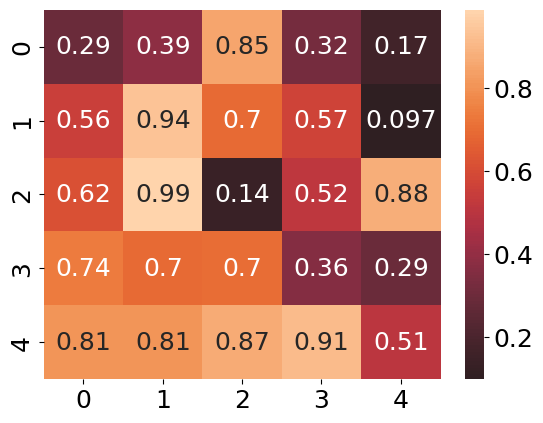

In [101]:
import seaborn as sns
import pandas as pd
import numpy as np

# Creation of a random dataset
data = pd.DataFrame(np.random.random((5,5)))

# Heatmap
sns.heatmap(data, center=0, annot=True)

#### Atribute selection based on the p-value

A p-value tells you: "If a feature didn’t actually matter (null hypothesis), what’s the probability of seeing its apparent effect just by random chance?"

- Low p-value (<0.05): The effect is probably real → keep the feature.
- High p-value (≥0.05): The effect is likely noise → discard it.

In [102]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def backward_elimination(x, y, significance_level=0.05, columns=None):
    """
    Performs backward elimination to remove statistically insignificant features.
    
    Parameters:
        x (ndarray): Feature matrix (no constant).
        y (ndarray): Target vector.
        significance_level (float): P-value threshold to keep features.
        columns (list or array): Feature names corresponding to x columns.

    Returns:
        x_selected (ndarray): Feature matrix with selected features.
        selected_columns (ndarray): Names of the selected features.
        decision_df (DataFrame): Feature-wise p-value and keep/drop decision.
    """
    if columns is None:
        columns = np.array([f"x{i}" for i in range(x.shape[1])])
    else:
        columns = np.array(columns)
    
    x_selected = x.copy()
    selected_columns = columns.copy()

    while True:
        model = sm.OLS(y, sm.add_constant(x_selected)).fit()
        pvalues = model.pvalues[1:]  # skip constant
        max_p = pvalues.max()

        if max_p > significance_level:
            remove_idx = pvalues.argmax()
            x_selected = np.delete(x_selected, remove_idx, axis=1)
            selected_columns = np.delete(selected_columns, remove_idx)
        else:
            break

    final_pvalues = model.pvalues[1:]  # final model p-values (no constant)
    decision_df = pd.DataFrame({
        'Feature': selected_columns,
        'p-value': final_pvalues,
        'Keep': final_pvalues <= significance_level
    })

    return x_selected, selected_columns, decision_df


# 1. Generate sample data
np.random.seed(42)
data = pd.DataFrame(np.random.random((50, 5)), 
                    columns=['target', 'x1', 'x2', 'x3', 'x4'])

# 2. Extract target and features
X = data.iloc[:, 1:].values   # Features: x1 to x4
y = data['target'].values     # Target
feature_names = data.columns[1:]  # ['x1', 'x2', 'x3', 'x4']
SIGNIFICANCE_LEVEL = 0.05

# 3. Run backward elimination
X_selected, selected_columns, decision_df = backward_elimination(
    X, y, SIGNIFICANCE_LEVEL, feature_names
)

# 4. Display result
print("\nFeature Selection Report:")
print(decision_df)
print("\nFinal selected features:", list(selected_columns))



Feature Selection Report:
  Feature   p-value  Keep
0      x2  0.018871  True

Final selected features: ['x2']


#### Visualize the selected features

Let's do that through histograms. This is useful to see the distribution of each variable, to give a visual idea (not mathematical)

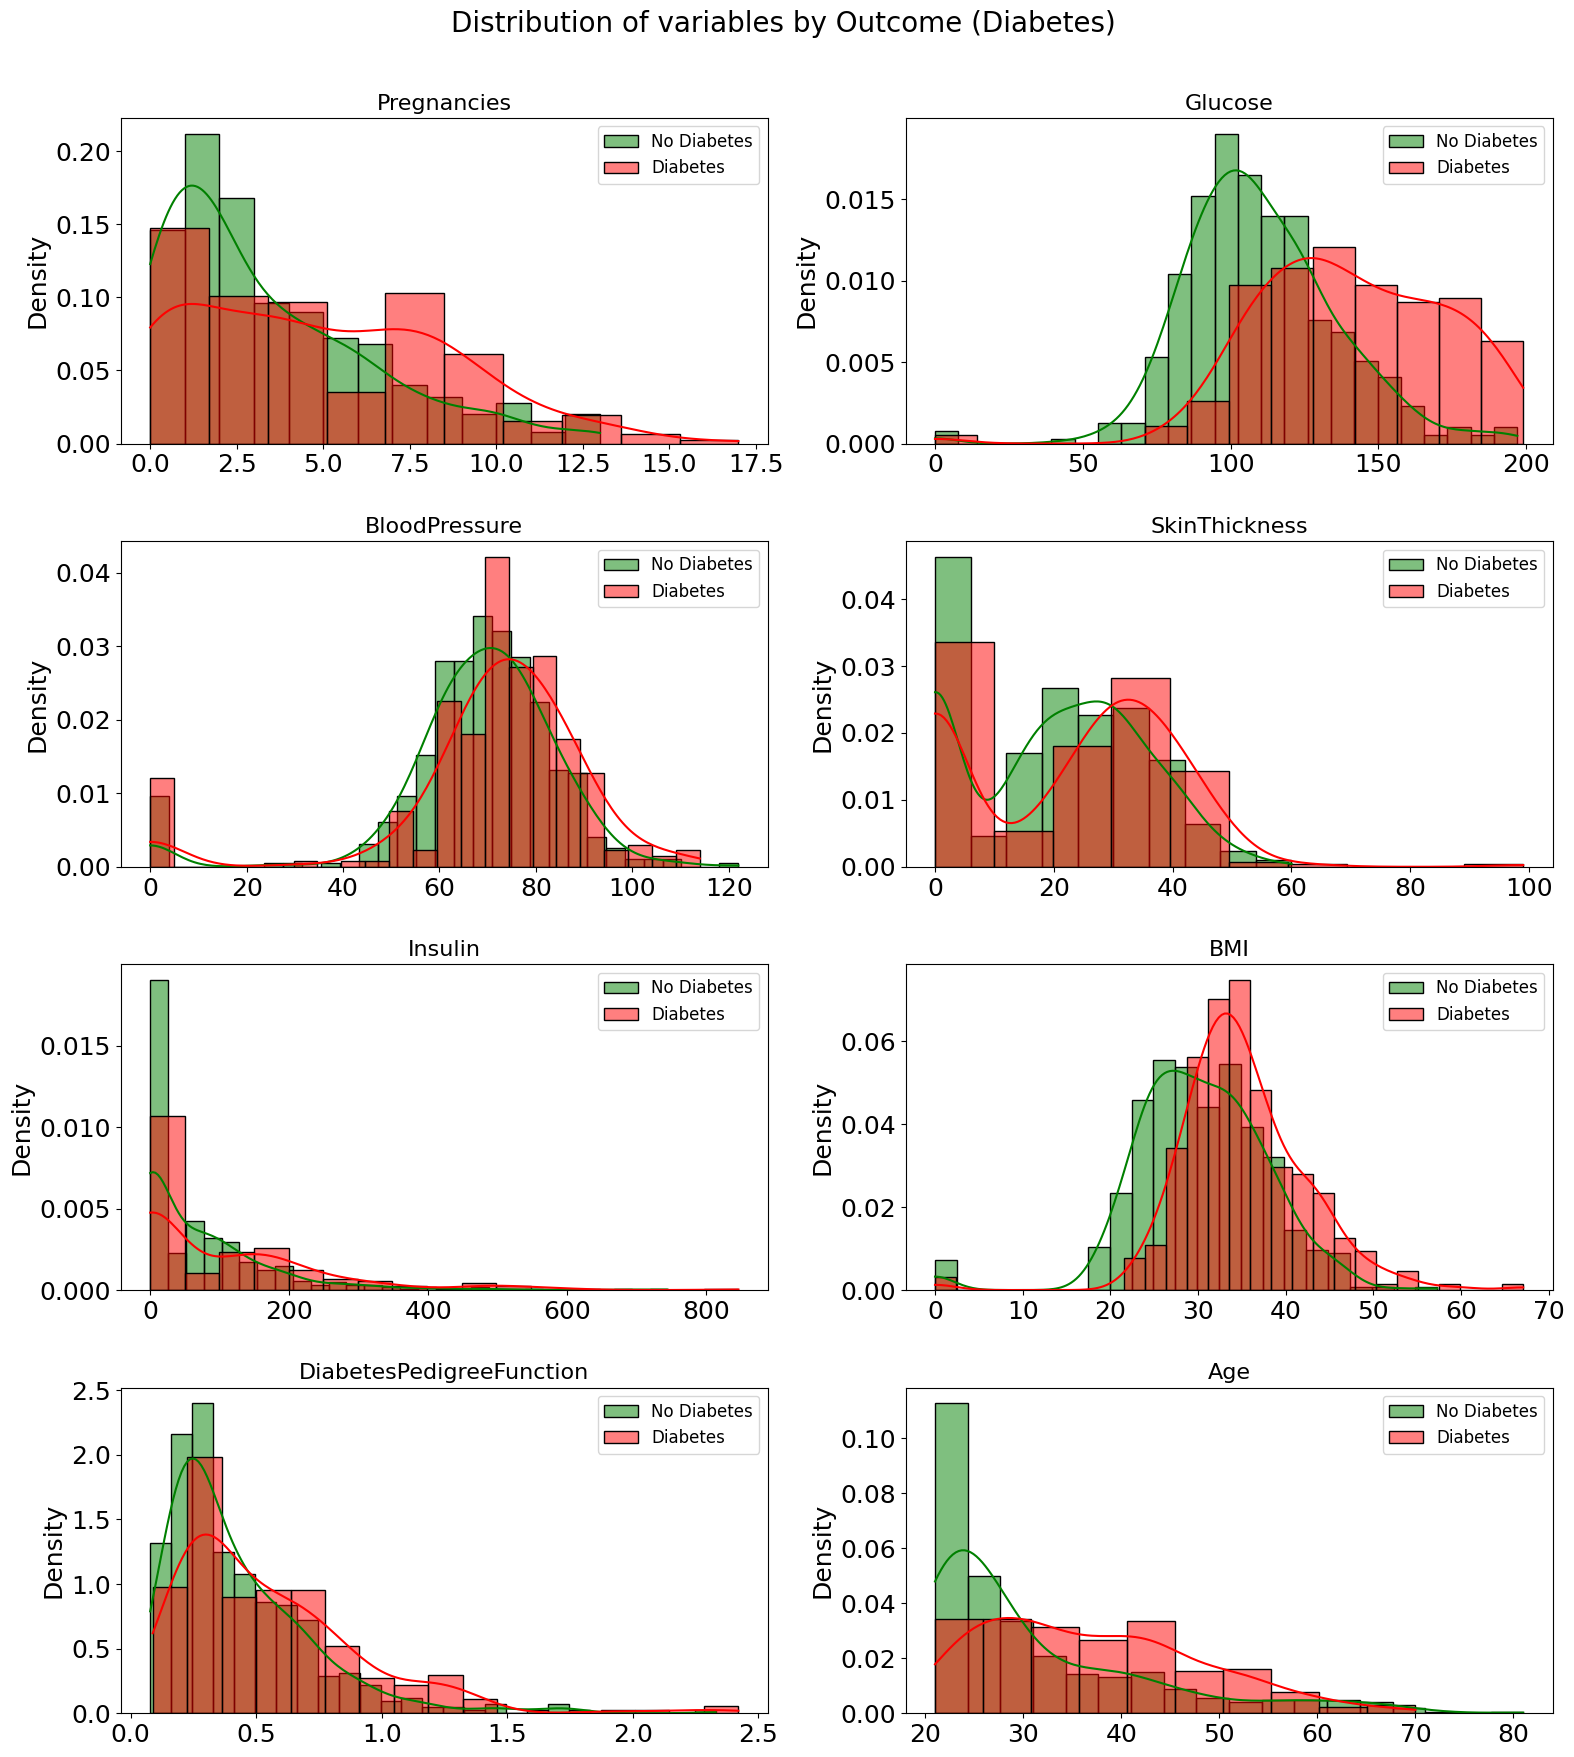

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 18))  # Més alt per donar més espai vertical
j = 0

for i in df.columns:
    if i == 'Outcome':
        continue
    plt.subplot(4, 2, j+1)  # 4 files, 2 columnes (8 subplots)
    j += 1
    sns.histplot(df[i][df['Outcome'] == 0], color='g', label='No Diabetes', kde=True, stat='density')
    sns.histplot(df[i][df['Outcome'] == 1], color='r', label='Diabetes', kde=True, stat='density')
    plt.legend(loc='upper right', fontsize=12)
    plt.title(i, fontsize=16)
    plt.xlabel('')
    plt.ylabel('Density')

fig.suptitle('Distribution of variables by Outcome (Diabetes)', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92, hspace=0.3)  # Espai vertical extra
plt.show()


## Additional exercises

Given the DataFrame below:

In [13]:
import pandas as pd

data = pd.read_csv("Iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [14]:
data.Species.value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [37]:
# define a set of two classes
df = data.copy()
df = df[df["Species"] != "Iris-virginica"]
feature_names = df.columns[1:-1]

mapping = {
    "Iris-setosa" : 0,
    "Iris-versicolor" : 1
}

X = df[feature_names].values
y = df.Species.map(mapping).values.reshape(100, 1)

#### Find the most important characteristics applying the following techniques
- Lineal Regression

Feature Importance Scores:
Feature 0: SepalLengthCm: -0.02639766599900132
Feature 1: SepalWidthCm: -0.17076425283556296
Feature 2: PetalLengthCm: 0.19689835189038948
Feature 3: PetalWidthCm: 0.3022307204264612


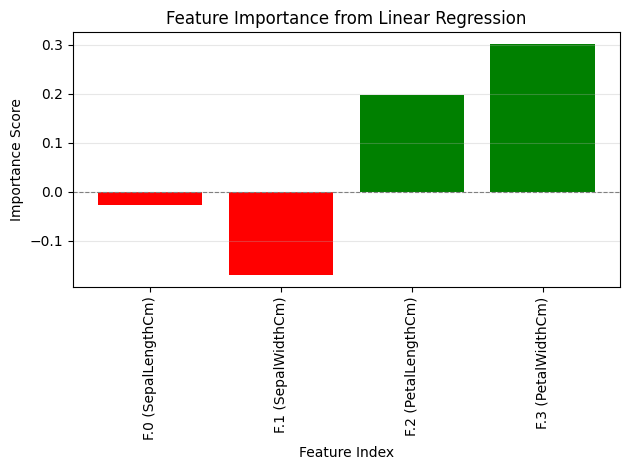

In [41]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy as np

# Define the model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get importance scores
importance_scores = model.coef_.flatten()

# Print the importance scores
print("Feature Importance Scores:")
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: {feature_names[i]}: {score}")  
    
# plot the feature importance
abs_importance = np.abs(importance_scores)
colors = ['green' if abs_score > np.median(abs_importance) else 'red' for abs_score in abs_importance]

pyplot.bar(range(len(importance_scores)), importance_scores, color=colors)
pyplot.xlabel('Feature Index')
pyplot.ylabel('Importance Score')
pyplot.title('Feature Importance from Linear Regression')
pyplot.xticks(range(len(importance_scores)), [f'F.{i} ({feature_names[i]})' for i in range(len(importance_scores))], rotation=90)
pyplot.tight_layout()
pyplot.axhline(0, color='grey', linewidth=0.8, linestyle='--')
pyplot.grid(axis='y', visible=True, alpha=0.3)
pyplot.show()
